In [1]:
from pathlib import Path

import librosa
import numpy
import pysptk
import pyworld

from become_yukarin.acoustic_converter import AcousticConverter
from become_yukarin.config.config import create_from_json as create_config
from become_yukarin.data_struct import Wave
from become_yukarin.dataset.dataset import *
from become_yukarin.dataset.utility import MFCCAligner, DTWAligner

from IPython.display import Audio
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
model_path = Path('./trained/mfcc8-wornn-small/predictor_1880000.npz')
config_path = Path('./trained/mfcc8-wornn-small/config.json')
config = create_config(config_path)
acoustic_converter = AcousticConverter(config, model_path, gpu=0)

c:\users\hihok\pycharm-env\become-yukarin\lib\site-packages\chainer\utils\experimental.py:104: FutureWarning: chainer.functions.pooling.MaxPoolingND is experimental. The interface can change in the future.
  FutureWarning)
c:\users\hihok\pycharm-env\become-yukarin\lib\site-packages\chainer\cuda.py:84: UserWarning: cuDNN is not enabled.
Please reinstall CuPy after you install cudnn
(see https://docs-cupy.chainer.org/en/stable/install.html#install-cupy-with-cudnn-and-nccl).
  'cuDNN is not enabled.\n'


In [3]:
paths = [
    Path('~/dataset/hiho-pause-atr503/').expanduser() / 'atr503-173.wav',
    Path('~/dataset/yukari-pause-atr503/').expanduser() / 'yukari-pause-atr-172.wav',
]

wave_file_load = WaveFileLoadProcess(
    sample_rate=24000,
    top_db=None,
    pad_second=0.05,
)
acoustic_feature = AcousticFeatureProcess(
    frame_period=5,
    order=8,
    alpha=pysptk.util.mcepalpha(wave_file_load._sample_rate),
)

In [4]:
w1 = wave_file_load(paths[0], test=True)
f1 = acoustic_feature(w1, test=True)
f1_ref = acoustic_converter.convert_to_feature(f1)

w2 = wave_file_load(paths[1], test=True)
f2 = acoustic_feature(w2, test=True)

In [5]:
aligner = MFCCAligner(f1_ref.mfcc, f2.mfcc)

f0_1, f0_2 = aligner.align(f1.f0, f2.f0)
spectrogram_1, spectrogram_2 = aligner.align(f1.spectrogram, f2.spectrogram)
aperiodicity_1, aperiodicity_2 = aligner.align(f1.aperiodicity, f2.aperiodicity)
mfcc_1, mfcc_2 = aligner.align(f1.mfcc, f2.mfcc)
voiced_1, voiced_2 = aligner.align(f1.voiced, f2.voiced)

f1 = AcousticFeature(
    f0=f0_1,
    spectrogram=spectrogram_1,
    aperiodicity=aperiodicity_1,
    mfcc=mfcc_1,
    voiced=voiced_1,
)
f2 = AcousticFeature(
    f0=f0_2,
    spectrogram=spectrogram_2,
    aperiodicity=aperiodicity_2,
    mfcc=mfcc_2,
    voiced=voiced_2,
)

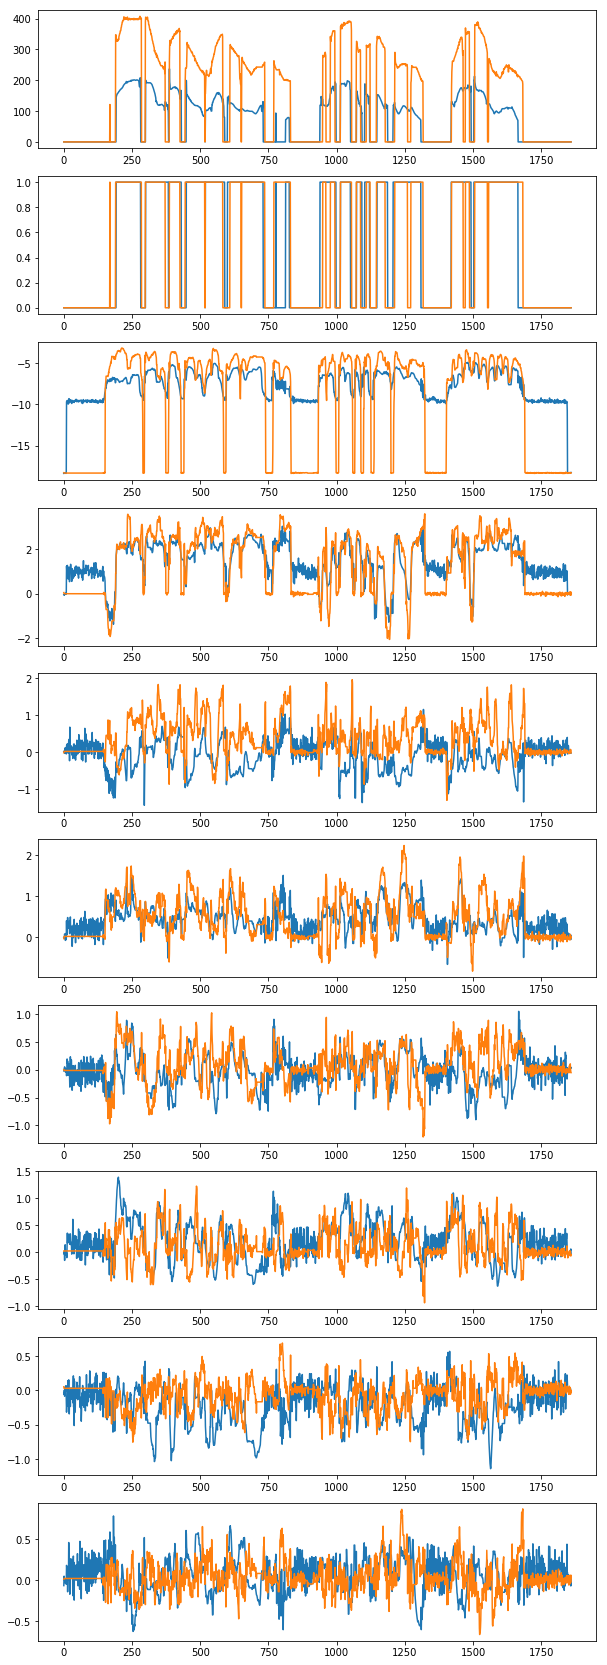

In [6]:
plt.figure(figsize=(10, 30))
ny = 2 + acoustic_feature._order

plt.subplot(ny, 1, 1)
plt.plot(f1.f0)
plt.plot(f2.f0)

plt.subplot(ny, 1, 2)
plt.plot(f1.f0!=0)
plt.plot(f2.f0!=0)

for i in range(acoustic_feature._order):
    plt.subplot(ny, 1, i+3)
    plt.plot(f1.mfcc[:,i])
    plt.plot(f2.mfcc[:,i])

In [7]:
def make_wave(f):
    fftlen = pyworld.get_cheaptrick_fft_size(wave_file_load._sample_rate)

    spectrogram = pysptk.mc2sp(
        f.mfcc,
        alpha=acoustic_feature._alpha,
        fftlen=fftlen,
    )

    f = AcousticFeature(
        f0=f.f0,
        spectrogram=spectrogram,
        aperiodicity=f.aperiodicity,
        mfcc=f.mfcc,
        voiced=f.voiced,
    ).astype(numpy.float64)

    out = pyworld.synthesize(
        f0=f.f0.ravel(),
        spectrogram=f.spectrogram,
        aperiodicity=f.aperiodicity,
        fs=wave_file_load._sample_rate,
        frame_period=acoustic_feature._frame_period,
    )
    return out

In [8]:
Audio(data=make_wave(f1), rate=wave_file_load._sample_rate)

In [9]:
Audio(data=make_wave(f2), rate=wave_file_load._sample_rate)